**IST664 - NLP Lab Week 8**

Word vectors are numeric representations of words in multidimensional space. Early popular word vectors include GloVe, a technique that obtains vectors from a large word co-occurence matrix developed from a corpus, and Word2vec, an predictive neural network training process that does repetitive, incremental training over strings of tokens in a corpus. There are also more recent word embeddings such as Elmo and BERT. In this lab, we will practice different word embedding techniques to convert text data into vectors of numeric data. The input text file is called "tweets.txt". There is a website reference for reading in the file, so it should not have to be uploaded to the file system of the virtual machine.

The total run time of this notebook without any of the code that you need to add for the lab is about eight minutes. Thus one strategy for working on the lab would be to click "Run All" (in the Runtime Menu) before the break. The code can then run during the break and you can come back to find all of your word embedding models loaded.

In [ ]:
!pip install --upgrade google-cloud-storage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.5/120.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.17.3
    Uninstalling google-auth-2.17.3:
      Successfully uninstalled google-auth-2.17.3
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 2.8.0
    Uninstalling google-cloud-storage-2.8.0:
      Successfully uninstalled google-cloud-storage-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
google-colab 1.0.0 requires google-auth==2.17.3, but you have google-auth 2.23.3 which is incompatible.


In [ ]:
# This takes about 2 minutes to complete and throws warnings
!pip install allennlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.2/730.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.2/248.2 kB 31.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 37.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8

In [ ]:
# If !pip install allennlp is run first, this does not need to run
#!pip install transformers

In [ ]:
# Here's a package for dealing with emojis
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 2.8 MB/s eta 0:00:00


In [36]:
# Here's all of the extra stuff we will need to run the examples
# ********* Import Packages ********* #
import re, nltk, emoji, torch, nltk
import numpy as np
from numpy import asarray, zeros
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import XLNetModel, XLNetTokenizer, BertTokenizer, BertModel
from allennlp.modules.elmo import Elmo, batch_to_ids
from gensim import models
print("Success!")

Success!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Next we will create some helper functions that will make the subsequent coding much cleaner. This first function simply assesses whether a character is an emoji.

In [37]:
# This function uses the English emoji dictionary to see if the
# first character of the input string is in the dictionary.
def char_is_emoji(character):
    #en_emoji = emoji.UNICODE_EMOJI.get("en")
    #return character[0] in emoji.UNICODE_EMOJI_ENGLISH
    return emoji.is_emoji(character[0])  #check out the API for emoji here: https://carpedm20.github.io/emoji/docs/api.html#

# Let's test it with a couple of examples
char_is_emoji("a"), char_is_emoji("👍")

(False, True)

In [ ]:
# Now we will add a layer to test every character in a string to see if it
# is an emoji.
def text_has_emoji(text):
    for character in text:
        if char_is_emoji(character):
            return True
    return False

text_has_emoji("Python is go!"), text_has_emoji("Python is go 👍")

(False, True)

In [38]:
# Here are three small dictionaries of substitutions that will be used in the
# clean_tweets() function defined below
slangs = {"afap":"as far as possible", "aab":"average at best", "aak":"alive and kicking", "aamof":"as a matter of fact", "aap":"always a pleasure", "aar":"at any rate", "aayf":"as always: your friend", "abd":"already been done", "admin":"administrator", "adn":"any day now", "aeae":"and ever and ever", "aeap":"as early as possible", "afaiac":"as far as i am concerned", "afaic":"as far as i am concerned", "afaics":"as far as i can see", "afaict":"as far as i can tell", "afaik":"as far as i know", "afair":"as far as i remember", "afc":"always from computer", "agw":"all going well", "afd":"all fucking day", "aft":"about fucking time", "b4":"before", "bb":"bye bye", "bbiab":"be back in a bit", "bbl":"be back later", "bbs":"be back soon", "bd":"big deal", "brb":"be right back", "brt":"be right there", "btw":"by the way", "cu":"see you", "cul":"see you later", "cuz":"because", "cya":"see you", "da":"the", "dat":"that", "der":"there", "dunno":"do not know", "fwiw":"for what it is worth", "fyi":"for your information", "g2g":"got to go", "gtg":"got to go", "gal":"get a life", "gfy":"good for you", "gonna":"going to", "icydk":"in case you do not know", "idgi":"i do not get it", "idk":"i do not know", "ily":"i love you", "ilu":"i love you", "imho":"in my honest opinion", "imo":"in my opinion", "irl":"in real life", "jj":"just joking", "jk":"just kidding", "k":"okay", "kk":"ok cool", "l8r":"later", "lmao":"laughing my ass off", "lmfao":"laughing my fucking ass off", "lol":"laughing out loud", "myob":"mind your own business", "noyb":"none of your business", "np":"no problem", "nsfw":"not safe for work", "nvm":"never mind", "omg":"oh my god", "pic":"picture", "ot":"off topic", "pix":"pictures", "plz":"please", "pls":"please", "ppl":"people", "rofl":"rolling on the floor laughing", "roflmao":"rolling on the floor laughing my ass off", "roflmaol":"rolling on the floor laughing my ass out loud", "smh":"shaking my head", "thnx":"thanks", "tho":"though", "tia":"thanks in advance", "ttyl":"talk to you later", "ttyt":"talk to you tomorrow", "ty":"thank you", "u":"you", "w8":"wait", "wanna":"want to", "wb":"welcome back", "wd":"well done", "im":"i am", "you've":"you have", "how'd":"how did", "i'm":"i am", "n't":"not", "we're":"we are", "you're":"you are"}
negated = {"weren't":"were not", "hadn't": "had not", "wouldn't": "would not", "mustn't": "must not", "aren't": "are not", "wasn't": "was not", "couldn't": "could not", "shan't": "shall not", "haven't": "have not", "mightn't": "might not", "doesn't": "does not", "needn't": "need not", "don't": "do not", "isn't": "is not", "hasn't": "has not", "doesn't": "does not", "didn't": "did not", "won't": "will not", "oughtn't": "ought not", "shouldn't": "should not", "cannot": "can not", "can't": "can not"}
emoticons = ["[: )", ":-]", ":-3", ":->", "8-)", ":-}", ":)", ":]", ":3", ":>", "8)", ":}", ":o)", ":c)", ":^)", "=]", "=)", ":-))", ": D", "8 D", "x D", "X D", ":D", "8D", "xD", "XD", "=D", "=3", "B^D", ":-*", ":*", ":×'", "; )", "*-)", "; ]", ";)", "*)", ";]", ";^)", ": ,", ";D", "<3", "(:", ": (", ": c", ": <", ": [", ":(", ":c", ":<", ":[", ":-||", ">:[", ":{", ":@", ">:(", ":' (", ":'(", "D ':", "D:<", "D:", "D8", "D;", "D=", "DX", ": O", ": o", ":O", ":o", ":-0", "8 0", ">:O"]

type(slangs), type(negated), type(emoticons)

(dict, dict, list)

In [39]:
#@title
# As an alternative to the code in the previous block, it would be possible
# to load the dictionaries from a file in the local file store. These are
# commented out as they are not needed if you run the previous code block.
#slangs = {}
#with open('lexicons/slangs.txt', 'r') as f:
#    for line in f:
#        splitted = line.strip().split(',', 1)
#        slangs[splitted[0]] = splitted[1]
#
#negated = {}
#with open('lexicons/negated_words.txt', 'r') as f:
#    for line in f:
#        splitted = line.strip().split(',', 1)
#        negated[splitted[0]] = splitted[1]
print("Hidden code is commented out and not needed.")

Hidden code is commented out and not needed.


In [40]:
# Next we will use our emoji finder to clean up the texts of a list of tweets.
# This function tokenizes the input and does many different transformations
# to the text and the tokens.



def clean_tweets(texts):
    cleaned_tweets = [] # This will be our return list
    hash_emos = [] # This is an overall list of emoticons and emojis

    # Loop over the full list of texts provided
    for text in texts:
        hash_emo = [] # Initialize an empty list for this one text

        # These make substitutions of short tags in place of repeating
        # exclamation marks and/or question marks.
        text = re.sub('(!){2,}', ' <!repeat> ', text)
        text = re.sub('(\?){2,}', ' <?repeat> ', text)

        # Tokenize using tweet tokenizer: This will treat each emoji as
        # its own token.
        tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=False, reduce_len=True)
        tokens = tokenizer.tokenize(text.lower())
        lemmatizer = WordNetLemmatizer()


        # Emojis and emoticons
        if text_has_emoji(text): # Examine the untokenized text
            temp = [] # Make temporary storage for the modified tokens
            for tok in tokens: # Cycle through each token in this text
                # If the token is an emoji, look up the equivalent
                # plain text placeholder.
                if char_is_emoji(tok):
                    hash_emo.append(emoji.demojize(tok))
                elif tok in emoticons:
                    hash_emo.append(tok)
                else:
                    temp.append(tok)
            tokens = temp

        # Hashtags
        temp = []
        for word in tokens:
            if '#' in word: # Do a simple substitution using the empty string
                word = word.replace('#','')
                hash_emo.append(word)
            else:
                temp.append(word)
        tokens = temp

        # Replace slangs and negated words
        temp = []
        for word in tokens:
            if word in slangs:
                temp += slangs[word].split()
            elif word in negated:
                temp += negated[word].split()
            else:
                temp.append(word)
        tokens = temp

        # Replace user names
        tokens = ['<user>'  if '@' in word else word for word in tokens]

        #Replace numbers
        tokens = ['<number>' if word.isdigit() else word for word in tokens]

        # Remove urls
        tokens = ['' if 'http' in word else word for word in tokens]

        # Lemmatize
        #tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # Remove stop words
        tokens = [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]

        # Remove tokens having length 1
        tokens = [word for word in tokens if word != '' and len(word) > 1]

        cleaned_tweets.append(tokens)
        hash_emos.append(hash_emo)

    return cleaned_tweets


atweet = """Nesthy Petecio celebrates her silver medal 🥈 in the Boxing Women's Featherweight division of the #Tokyo2020 Olympics, becoming the first Filipina ever to win a boxing medal!!!"""

clean_tweets([atweet])

[['nesthy',
  'petecio',
  'celebrates',
  'silver',
  'medal',
  'boxing',
  "women's",
  'featherweight',
  'division',
  'olympics',
  'becoming',
  'first',
  'filipina',
  'ever',
  'win',
  'boxing',
  'medal',
  '<!repeat>']]

In [41]:
#
# Exercise 8.1: Find another tweet on the web that contains an emoji
# and a repeating sequence like !!!. Run clean_tweets() on that
# string and review the results.
#

atweet = "Feeling happy today 😄!!! The sun is shining bright!!! #PositiveVibes @roshan"

clean_tweets([atweet])

[['feeling',
  'happy',
  'today',
  '<!repeat>',
  'sun',
  'shining',
  'bright',
  '<!repeat>',
  '<user>']]

In [42]:
# Utility functions

def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines) #check this page for details about this function fix_on_texts(): https://machinelearningknowledge.ai/keras-tokenizer-tutorial-with-examples-for-fit_on_texts-texts_to_sequences-texts_to_matrix-sequences_to_matrix/
    return tokenizer

def max_length(lines):
    return max([len(s) for s in lines])

# This is used in a future lab, but not in this one.
def encode_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [99]:
# ********* Load Data ********* #
# Important: Change load_data() function according to the dataset that you have.
# The following function processes the Twitter Emotion Corpus (TEC)
# Link of paper: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.383.3384&rep=rep1&type=pdf
# Link of web page with dataset: http://saifmohammad.com/WebPages/SentimentEmotionLabeledData.html


#zipurl = "http://saifmohammad.com/WebDocs/Jan9-2012-tweets-clean.txt.zip"
#zipfile = "Jan9-2012-tweets-clean.txt.zip"
basefile = "Jan9-2012-tweets-clean.txt"

# This downloads the zip file
!wget http://saifmohammad.com/WebDocs/Jan9-2012-tweets-clean.txt.zip
!unzip Jan9-2012-tweets-clean.txt.zip

# Initialize a list of tweets
texts = []

# Initialize a list of labels
labels = []

with open(basefile, 'r', encoding="utf8") as f:
  for line in f:
    splitted = line.strip().split()
    labels.append(splitted[len(splitted)-1])
    texts.append(' '.join(splitted[1:len(splitted)-2]))

print('Loaded %s  data' % len(labels))

--2023-10-31 17:03:32--  http://saifmohammad.com/WebDocs/Jan9-2012-tweets-clean.txt.zip
Resolving saifmohammad.com (saifmohammad.com)... 192.185.17.122
Connecting to saifmohammad.com (saifmohammad.com)|192.185.17.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1128895 (1.1M) [application/zip]
Saving to: ‘Jan9-2012-tweets-clean.txt.zip.2’

Jan9-2012-tweets-cl 100%[===================>]   1.08M  5.01MB/s    in 0.2s    

2023-10-31 17:03:32 (5.01 MB/s) - ‘Jan9-2012-tweets-clean.txt.zip.2’ saved [1128895/1128895]

Archive:  Jan9-2012-tweets-clean.txt.zip
replace Jan9-2012-tweets-clean.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: Loaded 21051  data


In [ ]:
# Take a look at some of the data. The labels list contains about six different
# options. These are labels that were added to the dataset by human annotators.

print(Counter(labels)) # Use Counter to get a summary of each category

# Show an example
print(texts[55])
print(labels[55])

Counter({'joy': 8240, 'surprise': 3849, 'sadness': 3830, 'fear': 2816, 'anger': 1555, 'disgust': 761})
literally haven't seen the sun in a week and it's finally coming out!
joy


In [44]:
#
# Exercise 8.2: Review a tweet with a label that is different from joy.
# You can just choose an index at random and try it in place of 55 in the code
# just above. Add a comment saying whether you agree with the label.
#

print(texts[54])
print(labels[54])


#The sentence shows an emotion of "anxiety" rather than "joy".

Guess I better start my psychology paper that's due Monday.
joy


In [ ]:
# Use our tweet cleaner to fix everything up. Because we are running an
# interpreted loop over a large number of instances, this takes
# about a minute to complete.
cleaned_tweets = clean_tweets(texts)
print("Cleaning Completed!")
len(cleaned_tweets)

Cleaning Completed!


21051

In [ ]:
# Let's examine one of these tweets
cleaned_tweets[0]

['thinks', '<user>', 'great', '50th', 'birthday', 'party', ':)']

In [45]:
# Now grab the GloVe embeddings we will need: Takes about a minute to download.
# Then it take about another minute to fill the data structure.
# Note that the zip file with the embeddings is hosted in Dropbox. If this does
# not work, it could be downloaded from the GloVe website and uploaded to the
# file store for this notebook.

#!wget https://www.dropbox.com/s/ewfdwppopt3pild/glove.twitter.27B.100d.txt.zip?dl=1

from google.colab import drive
drive.mount('/drive')

#from google.colab import files
#uploaded = files.upload()
#!unzip /drive/My Drive/Colab Notebooks/IST 664/glove.twitter.27B.100d.txt.zip?dl=1

print("Loading word embeddings...")
embeddings_index = dict() # Initialize an empty dictionary
embedding_dir = 'glove.twitter.27B.100d.txt'
#https://drive.google.com/file/d/1rAP6QM4fBEZUCz-bU6uAvX-8IwRg3hio/view?usp=sharing

f = open('/drive/My Drive/Colab Notebooks/IST 664/glove.twitter.27B.100d.txt', encoding='utf8')
#f = open(embedding_dir,encoding="utf8")
i = 1
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))



Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
Loading word embeddings...
Loaded 1193514 word vectors.


In [46]:
# Create a matrix that contains enough rows to handle each unique vocab
# item in the tweets and enough columns to capture all of the embedding
# vectors. Fill this up by doing lookups of each vocab word in the GloVe
# data structure embeddings_index.

dimension = 100

tokenizer_tweets = create_tokenizer(cleaned_tweets)

# According to the Keras documentation at https://keras.io/api/preprocessing/text/
# The index 0 is reserved. The doc does not say why, but some internet sources
# say that the 0th entry is used as "padding." When we iterate over word_index.items()
# below, the first "i" it returns is 1. Therefore to make sure all of our vocab
# fits in the structure, we need the expression in the next line.
vocab_size = len(tokenizer_tweets.word_index) + 1

# Generate embedding matrices
print("Generating embedding matrices...")

tweet_matrix = zeros((vocab_size, dimension))
for word, i in tokenizer_tweets.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        tweet_matrix[i] = np.array(list(embedding_vector))
    else:
        tweet_matrix[i] = np.array(list(np.random.uniform(low=-1, high=1, size=(dimension,))))
#    print(tweet_matrix[i])

print("Embedding matrices generation completed!")



Generating embedding matrices...
Embedding matrices generation completed!


In [ ]:
tweet_matrix.shape # Check the number of rows and columns. As we loaded the
# 100d GloVe model, there should be 100 columns.

(24681, 100)

In [ ]:
# Now we have a matrix of GloVe vectors for every vocab item in the tweets.
# What can we do with them? Let's look up a word. Remember that the first word
# embedding vector in tweet_matrix appears at index 1 rather than 0.

my_index = 1
print(list(tokenizer_tweets.word_index.items())[my_index-1])
tweet_matrix[my_index]



('<user>', 1)


array([ 0.63006002,  0.65177   ,  0.25545001,  0.018593  ,  0.043094  ,
        0.047194  ,  0.23218   ,  0.11613   ,  0.17371   ,  0.40487   ,
        0.022524  , -0.076731  , -2.29110003,  0.094127  ,  0.43292999,
        0.041801  ,  0.063175  , -0.64486003, -0.43656999,  0.024114  ,
       -0.082989  ,  0.21686   , -0.13462   , -0.22336   ,  0.39436001,
       -2.1724    , -0.39544001,  0.16536   ,  0.39438   , -0.35181999,
       -0.14996   ,  0.10502   , -0.45936999,  0.27728999,  0.89240003,
       -0.042313  , -0.009345  ,  0.55017   ,  0.095521  ,  0.070504  ,
       -1.17809999,  0.013723  ,  0.17742001,  0.74141997,  0.17715999,
        0.038468  , -0.31683999,  0.08941   ,  0.20557   , -0.34327999,
       -0.64302999, -0.87800002, -0.16293   , -0.055925  ,  0.33897999,
        0.60663998, -0.27739999,  0.33625999,  0.21603   , -0.11051   ,
        0.0058673 , -0.64757001, -0.068222  , -0.77414   ,  0.13911   ,
       -0.15851   , -0.61884999, -0.10192   , -0.47      ,  0.19

In [47]:
#
# Exercise 8.3: Change my_index in the code block above to a number
# higher than 1 and review the word and its embedding.
#
my_index = 4
print(list(tokenizer_tweets.word_index.items())[my_index-1])
tweet_matrix[my_index]

('..', 4)


array([ 0.15952121, -0.93675069,  0.8848727 ,  0.03825245,  0.19158554,
       -0.2955281 ,  0.69640205, -0.31658665, -0.98996306, -0.59922794,
        0.04872157,  0.78128715,  0.07218131,  0.59322354, -0.04471679,
        0.98054175,  0.43082555,  0.41457807, -0.33271632, -0.70078749,
       -0.15813116,  0.00966944,  0.43033075, -0.28810573,  0.72367865,
       -0.57484874, -0.62942437, -0.54354438, -0.26840451,  0.10936485,
        0.4605114 , -0.46090408, -0.56574852, -0.17621721, -0.22259952,
        0.22010615, -0.46130616,  0.70986709, -0.50578003, -0.44577334,
       -0.1969113 ,  0.56398482,  0.19652086, -0.87696622, -0.57926659,
       -0.91428925, -0.91578413,  0.00700817,  0.57822774, -0.85062663,
        0.59503296, -0.37778651, -0.83089738, -0.17112444,  0.80399986,
       -0.93314332,  0.24460024,  0.61786373, -0.80256341,  0.12061536,
       -0.99126971, -0.64011629, -0.13164039,  0.59922035,  0.82722268,
        0.46297332, -0.37638789, -0.19858283, -0.61781141, -0.76

In [ ]:
len(tweet_matrix[1])

100

In [ ]:
#!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
#!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
#!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
#!wget -c "https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g/"
#!gzip -d GoogleNews-vectors-negative300.bin.gz



In [50]:
############# we use word2vec for word embedding #############

#https://drive.google.com/file/d/1Q8TFtBe1TgkKzAUbf3W8qCA2mnrtTHd1/view?usp=sharing
word2vec_vectors = models.KeyedVectors.load_word2vec_format(
    '/drive/My Drive/Colab Notebooks/IST 664/GoogleNews-vectors-negative300.bin', binary=True)
dimension = 300
print(word2vec_vectors)
word2vec_tweet_matrix = zeros((vocab_size, dimension))
for word, i in tokenizer_tweets.word_index.items():
    if word in word2vec_vectors:
        word2vec_tweet_matrix[i] = np.array(list(word2vec_vectors[word]))
    else:
        word2vec_tweet_matrix[i] = np.array(list(np.random.uniform(low=-1, high=1, size=(dimension,))))
#    print(word2vec_tweet_matrix[i])




KeyedVectors<vector_size=300, 3000000 keys>


In [51]:
############# we use BERT for word embedding ##############
# source code from https://datascience.stackexchange.com/questions/62658/how-to-get-sentence-embedding-using-bert
#an article: https://towardsdatascience.com/how-to-use-bert-from-the-hugging-face-transformer-library-d373a22b0209
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
sentence='I really enjoyed this movie a lot.'
encoded_input = tokenizer.encode(sentence, return_tensors="pt")
output = bert_model(encoded_input)
print("The token representation in " + sentence + "is \n", output.last_hidden_state)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The token representation in I really enjoyed this movie a lot.is 
 tensor([[[ 0.3582, -0.4257, -0.0340,  ...,  0.0060,  0.3476,  0.1494],
         [ 0.4394, -0.4750, -0.3830,  ..., -0.1403,  1.1409,  0.1050],
         [ 0.7339, -0.7106, -0.3237,  ..., -0.3432,  0.5855, -0.3660],
         ...,
         [ 0.3494, -0.5298, -0.0804,  ...,  0.2450,  0.2246, -0.0978],
         [ 0.5115, -0.0925, -0.1743,  ...,  0.1119, -0.2674, -0.4251],
         [ 0.3200, -0.0759,  0.1520,  ...,  0.5135, -0.2743, -0.2685]]],
       grad_fn=<NativeLayerNormBackward0>)


In [57]:
#8.4 obtain BERT vector embedding for the first two Twitter data and print them

encoded_input = tokenizer.encode(cleaned_tweets[0], return_tensors="pt")
output = bert_model(encoded_input)
sentence = cleaned_tweets[0]
print("The token representation for tweet 1 is \n", output.last_hidden_state)


sentence = cleaned_tweets[1]
encoded_input = tokenizer.encode(cleaned_tweets[1], return_tensors="pt")
output = bert_model(encoded_input)
print("The token representation for tweet 2 is \n", output.last_hidden_state)

The token representation for tweet 1 is 
 tensor([[[-0.2258,  0.1785, -0.0879,  ..., -0.2794,  0.4903,  0.1265],
         [ 0.3523,  0.0721,  0.5121,  ..., -0.2080,  0.4022, -0.3151],
         [-0.1239, -0.0185,  0.7561,  ...,  0.1545,  0.1034,  0.2282],
         ...,
         [-0.8715, -0.5080,  0.6794,  ...,  0.1494,  0.1064, -0.1004],
         [-0.5764, -0.5801,  0.1563,  ...,  0.6489,  0.1286, -0.2256],
         [ 0.6480,  0.3481,  0.0917,  ...,  0.4565, -0.6316, -0.2761]]],
       grad_fn=<NativeLayerNormBackward0>)
The token representation for tweet 2 is 
 tensor([[[-0.4578,  0.4611, -0.4015,  ..., -0.4402,  0.3530,  0.3147],
         [ 0.0885,  0.1086, -0.2495,  ..., -0.3429, -0.2463,  0.6791],
         [-0.3871, -0.3610, -0.3197,  ..., -0.4592,  0.0887,  0.7253],
         ...,
         [-0.2753,  0.6812, -0.0257,  ..., -0.7204,  0.2849, -0.3349],
         [-0.6587,  0.2800, -0.5471,  ..., -0.3533,  0.2485, -0.3560],
         [ 0.4078,  0.2860, -0.3942,  ...,  0.0225, -0.6620, -

In [58]:
# Get files for elmo from dropbox
!wget https://www.dropbox.com/s/cmdsttnzr66cpkb/options.json?dl=1
options_file = 'options.json?dl=1'

!wget https://www.dropbox.com/s/bn1hmusxwq50f2e/weights.hdf5?dl=1
weight_file = 'weights.hdf5?dl=1'

--2023-10-31 16:36:09--  https://www.dropbox.com/s/cmdsttnzr66cpkb/options.json?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/cmdsttnzr66cpkb/options.json [following]
--2023-10-31 16:36:09--  https://www.dropbox.com/s/dl/cmdsttnzr66cpkb/options.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf9469d488d31b61a0a9c247749.dl.dropboxusercontent.com/cd/0/get/CGptOwmr0eGC9E9W2PBVkrhsBHNxIXsJu9rdorLomj1acr0tuUgm6DTDEGKrb_aoSPmbJxI8Z_jCCHdzas4y9pFlZvnGJAXwmV0nu92D-ILnBnh3R0AjzMrSVKYWoupKpSPu1xrz8MftTtidfLaRUwgT/file?dl=1# [following]
--2023-10-31 16:36:09--  https://ucf9469d488d31b61a0a9c247749.dl.dropboxusercontent.com/cd/0/get/CGptOwmr0eGC9E9W2PBVkrhsBHNxIXsJu9rdorLomj1acr0tuUgm6DTDEGKrb_aoSPmbJxI8Z_jCCHdzas4y9pFlZvnGJAXwmV0n

In [59]:
############# we use ELMO for word embedding #############

sentences=['I really enjoyed this movie a lot.', 'I am happy.']
elmo_model = Elmo(options_file=options_file, weight_file=weight_file,
                num_output_representations=1, dropout=0.3, requires_grad=False,do_layer_norm=True)
tokens = [nltk.word_tokenize(text) for text in sentences]

character_ids = batch_to_ids(tokens)
elmo_embs = elmo_model(character_ids)['elmo_representations']
print("The token representation is ", elmo_embs[0])

The token representation is  tensor([[[ 0.0000, -0.0000,  0.0828,  ...,  0.1907,  0.3396, -0.0000],
         [ 0.0000, -0.1505, -0.0517,  ...,  0.1164, -0.0000,  0.0000],
         [-0.6227, -0.3249, -0.1599,  ..., -0.1374, -0.5435,  0.1589],
         ...,
         [-0.0000, -0.5467, -0.0000,  ...,  0.1904,  0.1475,  0.2457],
         [ 0.5665, -0.6002,  0.0000,  ..., -1.4920, -0.3407, -0.7940],
         [ 0.0000,  0.2206,  0.4666,  ..., -0.2100,  0.0000,  0.1361]],

        [[ 0.6851, -0.7621,  0.0000,  ...,  0.2069, -0.0000,  0.0426],
         [ 0.0706, -1.0656, -0.4043,  ..., -0.3354, -0.2849, -0.3982],
         [-0.1585, -0.0000,  0.0466,  ...,  0.3179,  0.3930, -0.5786],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<MulBackward0>)


In [63]:
#8.5 obtain Elmo word embedding for the first two Twitter data and print them

tokens = [nltk.word_tokenize(text) for text in cleaned_tweets[0]]

character_ids = batch_to_ids(tokens)
elmo_embs = elmo_model(character_ids)['elmo_representations']
print("The token representation is ", elmo_embs[0])


tokens = [nltk.word_tokenize(text) for text in cleaned_tweets[1]]

character_ids = batch_to_ids(tokens)
elmo_embs = elmo_model(character_ids)['elmo_representations']
print("\nThe token representation is ", elmo_embs[0])

The token representation is  tensor([[[-0.2737,  0.0607, -0.0303,  ...,  0.1215, -0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.4526, -0.5747, -0.3534,  ..., -0.1179,  0.0805,  0.5196],
         [ 0.9500, -0.1823, -0.1744,  ..., -1.0382,  0.0000,  0.0000],
         [-0.0000, -0.0634,  0.0000,  ..., -0.8914, -1.2330,  0.1480]],

        [[-0.0019, -0.0653, -0.4154,  ...,  0.0000, -0.1289, -0.1808],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        ...,

        [[ 0.2534,  0.9938, -0.0000,  ...,  0.0000, -0.0000, -0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0602, -0.1268, -0.6407,  ..., -0.0000, -0.8108, -0.1436],
         [ 0.0000,  0.0000

In [64]:
from numpy.core.fromnumeric import size
from transformers import XLNetModel, XLNetTokenizer
############ we use XLNet for word embedding ############
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetModel.from_pretrained('xlnet-base-cased')
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)
print("The token representation in the sentence is ", outputs.last_hidden_state)

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The token representation in the sentence is  tensor([[[ 2.0336e+00, -2.2855e+00, -3.5177e+00,  ..., -1.4426e+00,
           4.4805e-01,  1.7478e+00],
         [ 1.7492e+00, -4.1622e+00, -1.9760e+00,  ..., -3.2956e+00,
          -5.6335e-02,  1.0577e+00],
         [ 2.0526e+00, -3.0355e+00, -9.3958e-01,  ..., -5.1129e+00,
           1.8165e-01,  2.9342e+00],
         ...,
         [ 3.7707e-01, -3.5917e+00, -3.0442e+00,  ..., -6.4846e-01,
          -3.7836e-01,  2.6249e+00],
         [ 5.0123e+00,  3.0843e-03, -4.3199e+00,  ..., -2.1635e+00,
           1.8763e-01,  9.7331e-01],
         [ 4.6562e+00,  5.4449e-01, -4.1356e+00,  ..., -1.3859e+00,
           6.2713e-02,  1.0305e+00]]], grad_fn=<PermuteBackward0>)


In [67]:
#8.6 obtain XLNet word embedding for the first two Twitter data and print them


inputs = tokenizer(cleaned_tweets[0], return_tensors="pt",padding=True,truncation=True)
outputs = model(**inputs)
print("The token representation in the sentence is ", outputs.last_hidden_state)

inputs = tokenizer(cleaned_tweets[1], return_tensors="pt",padding=True,truncation=True)
outputs = model(**inputs)
print("The token representation in the sentence is ", outputs.last_hidden_state)

The token representation in the sentence is  tensor([[[ 5.2620, -1.8042, -3.7020,  ..., -2.2855,  0.8659,  2.2533],
         [ 5.5903, -1.7784, -4.0208,  ..., -2.6463,  0.6157,  2.2548],
         [ 4.5724, -1.5520, -3.8543,  ..., -2.7663,  0.5143,  2.2675],
         [ 5.1282, -1.0699, -4.1390,  ..., -2.9645,  0.3071,  1.4127],
         [ 4.8004, -1.0357, -4.1585,  ..., -2.7598,  0.3328,  1.4331]],

        [[ 0.5919,  1.8768, -0.8192,  ..., -2.0105,  2.0635,  1.7239],
         [ 1.0161,  2.4480, -1.3330,  ..., -1.8800,  2.5214,  1.5587],
         [ 1.6063,  1.2728, -1.8653,  ..., -1.8814,  2.3869,  1.6844],
         [ 1.9738,  1.3621, -1.9110,  ..., -1.4138,  1.8233,  0.7614],
         [ 1.3659,  1.6105, -2.0000,  ..., -1.2013,  1.2910,  0.8610]],

        [[ 5.5169, -2.6482, -4.1060,  ...,  1.0675,  2.2923,  2.2931],
         [ 5.3913, -2.6159, -3.9393,  ...,  0.3277,  2.0713,  2.8296],
         [ 3.8395, -1.4216, -2.9526,  ...,  0.5178,  3.3533,  1.6062],
         [ 3.4189, -0.6521, 

# Word Embedding in spaCy and Cosine Similarity

SpaCy language models come in two sizes: small and large. The small models do not contain word vectors - a space saving strategy. So if we want to use word vectors, we need to load the large version of a language model as shown in the next cell. You can see the different available models (and their sizes) here. Note that because of the size of the file, the next code cell may take about three minutes to complete.

Word vectors have the interesting property that semantically similar words appear close to each other in multidimensional space. Given any two word vectors, we can calculate the similarity (or distance) between them.

In [68]:
import spacy.cli # Use the command line interface
spacy.cli.download("en_core_web_lg") # This imports the large model onto your virtual machines
import en_core_web_lg # Now that it is downloaded, we can import it
nlp_lg = en_core_web_lg.load() # Create an instance for further use
type(nlp_lg)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


spacy.lang.en.English

In [69]:
# Let's get the vectors for three words to examine similarities
apple = nlp_lg.vocab["apple"]
banana = nlp_lg.vocab["banana"]
car = nlp_lg.vocab["car"]

print(apple.vector) # Take a look at one of them

[-3.6391e-01  4.3771e-01 -2.0447e-01 -2.2889e-01 -1.4227e-01  2.7396e-01
 -1.1435e-02 -1.8578e-01  3.7361e-01  7.5339e-01 -3.0591e-01  2.3741e-02
 -7.7876e-01 -1.3802e-01  6.6992e-02 -6.4303e-02 -4.0024e-01  1.5309e+00
 -1.3897e-02 -1.5657e-01  2.5366e-01  2.1610e-01 -3.2720e-01  3.4974e-01
 -6.4845e-02 -2.9501e-01 -6.3923e-01 -6.2017e-02  2.4559e-01 -6.9334e-02
 -3.9967e-01  3.0925e-02  4.9033e-01  6.7524e-01  1.9481e-01  5.1488e-01
 -3.1149e-01 -7.9939e-02 -6.2096e-01 -5.3277e-03 -1.1264e-01  8.3528e-02
 -7.6947e-03 -1.0788e-01  1.6628e-01  4.2273e-01 -1.9009e-01 -2.9035e-01
  4.5630e-02  1.0120e-01 -4.0855e-01 -3.5000e-01 -3.6175e-01 -4.1396e-01
  5.9485e-01 -1.1524e+00  3.2424e-02  3.4364e-01 -1.9209e-01  4.3255e-02
  4.9227e-02 -5.4258e-01  9.1275e-01  2.9576e-01  2.3658e-02 -6.8737e-01
 -1.9503e-01 -1.1059e-01 -2.2567e-01  2.4180e-01 -3.1230e-01  4.2700e-01
  8.3952e-02  2.2703e-01  3.0581e-01 -1.7276e-01  3.2536e-01  5.4696e-03
 -3.2745e-01  1.9439e-01  2.2616e-01  7.4742e-02  2

In [70]:
# A spaCy lexeme, with a variety of attribute tests available
type(apple), [m for m in dir(apple) if m[0:3] == "is_"]

(spacy.lexeme.Lexeme,
 ['is_alpha',
  'is_ascii',
  'is_bracket',
  'is_currency',
  'is_digit',
  'is_left_punct',
  'is_lower',
  'is_oov',
  'is_punct',
  'is_quote',
  'is_right_punct',
  'is_space',
  'is_stop',
  'is_title',
  'is_upper'])

In [71]:
# We can also confirm that a lexeme has a vector representation available
banana.has_vector

True

In [73]:
# The .similarity() bound method allows us to generate a cosine similarity
# score for two vectors.
apple.similarity(banana)

0.5831844806671143

In [74]:
# The similarity is transitive, and by the calculation spaCy uses, seems
# to result in values in the interval 0 to 1. Higher values indicate
# closer similarity.
banana.similarity(apple)

0.5831844806671143

In [75]:
apple.similarity(car)

0.2174709141254425

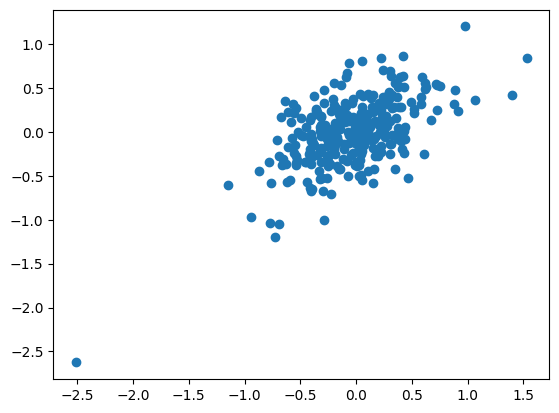

In [76]:
# A scatterplot of two similar vectors should indicate linearity
import matplotlib.pyplot as plt # Make a simple plot
plt.scatter(apple.vector, banana.vector) # Show the result

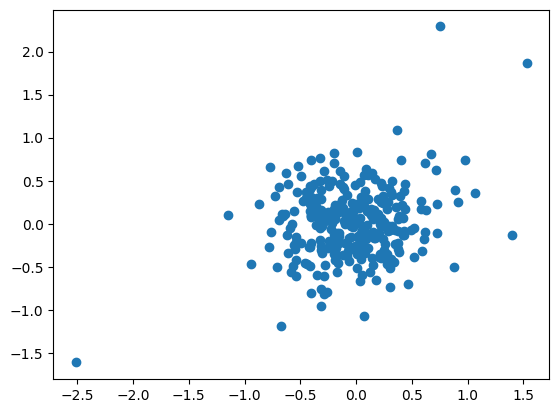

In [77]:
# A scatterplot of two different vectors should be a circular cloud
plt.scatter(apple.vector, car.vector)

In [78]:
# There are many options for a cosine similarity calculation,
# including this one from scipy that we are not using here.

#from scipy.spatial.distance import cosine

In [79]:
# With some help from numpy, we can calculate our own cosine scores
# using a vector dot product, computed with np.dot()
import numpy as np
def cosine(x,y):
    return np.dot(x,y) / (np.sqrt(np.dot(x,x)) * np.sqrt(np.dot(y,y)))

In [80]:
# One of the notable aspects of word vectors is the possibility of
# doing simple math to create analogies.
man = nlp_lg.vocab["man"].vector
woman = nlp_lg.vocab["woman"].vector
king = nlp_lg.vocab["king"].vector
queen = nlp_lg.vocab["queen"].vector

analogy = king - man + woman # Calculate the analogy with vector math
cosine(analogy, queen)

0.78808445

In [81]:
# Let's compare the analogy to another vector
cosine(analogy, car.vector) # Note how we needed to extract the vector for car

0.13843127

In [84]:
# Now you compute an anology and see what kind of results you get

# 8.7: Obtain the vectors for Paris, France, Berlin, and Germany

Paris = nlp_lg.vocab["Paris"].vector
France = nlp_lg.vocab["France"].vector
Berlin = nlp_lg.vocab["Berlin"].vector
Germany = nlp_lg.vocab["Germany"].vector

# 8.8: Compute an analogy using three of these vectors
analogy = Paris + France + Berlin

# 8.9: Find the cosine similarity of the analogy with the fourth vector
print(cosine(analogy, Germany))

# 8.10: Find the cosine similarity of the analogy with banana
print(cosine(analogy, banana.vector))


0.74984705
0.17311805


**Sentence Similarity - spaCy**

As you have seen above, word vectors for similar words have similar patterns and though we don't know what each position in a vector signifies, these patterns support simple vector math for analogical reasoning. This suggests the possibility - which research seems to back up - that averaging two or more vectors provides a semantic summary of the vectors. Document and span objects in spaCy have attached vectors that repesents the average of all of the component word vectors.

In [85]:
doc1 = nlp_lg("The quick brown fox jumps over the lazy dog.")
doc2 = nlp_lg("The lazy dog jumps over the quick brown fox.")
doc1.similarity(doc1)

1.0

In [86]:
# We can also manually calculate the cosine similarity. It should be transitive
# such that cosine(A,B) == cosine(B,A)
doc1_vec = doc1.vector
doc2_vec = doc2.vector
cosine(doc2_vec, doc1_vec), cosine(doc1_vec, doc2_vec)

(1.0, 1.0)

In [87]:
docdiff = nlp_lg("Four score and seven years ago, our fathers brought forth upon this continent a new nation.")
cosine(docdiff.vector, doc1_vec)

0.72331554

In [88]:
# The semantics can be quite muddled by the averaging process. These two
# sentences express the opposite sentiment
doc3 = nlp_lg("I like snow")
doc4 = nlp_lg("I hate snow")
cosine(doc3.vector, doc4.vector)

0.94878143

In [97]:
#
# Exercise 8.11: Parse the following two sentences to remove stop words and
# punctuation. Then create a summary word vector for each sentence by averaging
# across the word vectors for each sentence. Use whichever of the word vector
# databases from above according to your preference.
#

sentence1 = "The lazy brown cow jumped over the moon."
sentence2 = "Brown shoes look black in the light of the moon."

# import spacy

# !python -m spacy downlaod en_core_web_sm
# nlp = spacy.load('en_core_web_sm')

def remove_stop_punct (sent):
  doc = nlp_lg(sent)
  tokens = [tokens for tokens in doc if not tokens.is_stop and not tokens.is_punct]
  word_vectors = [tokens.vector for tokens in tokens]
  return word_vectors

word_vectors1 = remove_stop_punct (sentence1)
word_vectors2 = remove_stop_punct (sentence2)

print("summar vect1: ", np.mean(word_vectors1))
print("summar vect1:" , np.mean(word_vectors2))

summar vect1:  -0.022122081
summar vect1: -0.020601766


In [98]:
#
# Exercise 8.12: Calculate the cosine similarity between the two sentence
# summaries you computed in the previous step.
#

cosine(np.mean(word_vectors1),np.mean(word_vectors2))

1.0